In [1]:
import sys

import pandas as pd
import numpy as np
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

from helper_funcs import eta_2_log_Gamma
from helper_funcs import log_Gamma_2_eta
from helper_funcs import eta0_2_log_delta
from helper_funcs import log_delta_2_eta0
from helper_funcs import logdotexp

# Initialize Parameters

In [2]:
# parameters for model
K = [2,3]
jump_every = 1

features = [{},
            {'diveDuration'     : {'f'           : 'normal',
                                   'lower_bound' : None,
                                   'upper_bound' : None,
                                   'share_fine'  : True,
                                   'share_coarse': False},
             'maxDepth'         : {'f'           : 'normal',
                                   'lower_bound' : np.array([-np.infty,-np.infty,-np.infty,np.log(5),np.log(5)]),
                                   'upper_bound' : np.array([np.log(20),np.log(20),np.log(20),np.infty,np.infty])},
             'avg_bot_htv'      : {'f'           : 'normal',
                                   'lower_bound' : None,
                                   'upper_bound' : None}}]#,
             #'avg_bot_abs_roll' : {'f'           : 'normal',
             #                      'lower_bound' : None,
             #                      'upper_bound' : None}}]#,
             #'postDiveInt'      : {'f'           : 'normal',
             #                      'lower_bound' : None,
             #                      'upper_bound' : None}}]#,
             #'max_bot_jp'       : {'f'           : 'normal',
             #                      'lower_bound' : None,
             #                      'upper_bound' : None}}]
             #'broadDiveType'    : {'f':'bern'}}],
             #'foraging'         : {'f':'bern'},
             #'scales'           : {'f':'bern'},
             #'click.train'      : {'f':'bern'},
             #'whales'           : {'f':'bern'}}]

# optimization parameters 
methods = ["BFGS"]#,"L-BFGS-B"]
num_epochs = 100
tol = 1e-8
grad_tol = 1e-8

# Load in Whale Data

In [3]:
df = pd.read_csv("../../dat/Final_Data_Beth.csv")

In [4]:
# load in data
df = pd.read_csv("../../dat/Final_Data_Beth.csv")

whales = pd.unique(df.ID)
df = df[df["ID"].isin(whales)]

# convert times
df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# force dives to be at least 2 seconds long
df = df[df["diveDuration"] > np.log(2.0)]

# replace -inf 
df["max_bot_jp"][df["max_bot_jp"] == -np.infty] = np.NAN

df["broadDiveType"] = np.NAN #3  # unknown
df.loc[df["maxDepth"] > np.log(20),"broadDiveType"] = 1  # deep
df.loc[df["maxDepth"] < np.log(5),"broadDiveType"] = 0  # shallow

# populate a data object

data = []

initial_ts = [0]
final_ts = []

for t,row in enumerate(df.iterrows()):
    
    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)
     
    data.append({"diveDuration"     : row[1]["diveDuration"],
                 "maxDepth"         : row[1]["maxDepth"],
                 "postDiveInt"      : np.log(max(0.5,row[1]["postDiveInt"]))})
                 #"avg_bot_htv"      : row[1]["avg_bot_htv"]})#,
                 #"avg_bot_abs_roll" : row[1]["avg_bot_abs_roll"]})
                 #"postDiveInt"      : np.log(row[1]["postDiveInt"])})
                 #"max_bot_jp"       : row[1]["max_bot_jp"]})#,
                 #"foraging"         : row[1]["foraging"],
                 #"scales"           : row[1]["scales"],
                 #"click.train"      : row[1]["click.train"],
                 #"whales"           : row[1]["whales"]})
                
final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

In [5]:
#for feature in features:
#    print(feature)
#    plt.plot([datum[feature] for datum in data])
#    plt.show()

In [6]:
raw_df = pd.read_csv("../../dat/Final_rawData_Beth.csv", 
                      usecols = ["Time","p","head","pitch","roll","divenum"],
                      low_memory = True)

In [7]:
raw_df["Elevation"] = -raw_df["p"]
raw_df["Time"] = pd.to_datetime(raw_df["Time"])
raw_df = raw_df.reset_index(drop=True)

A100


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_85414/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


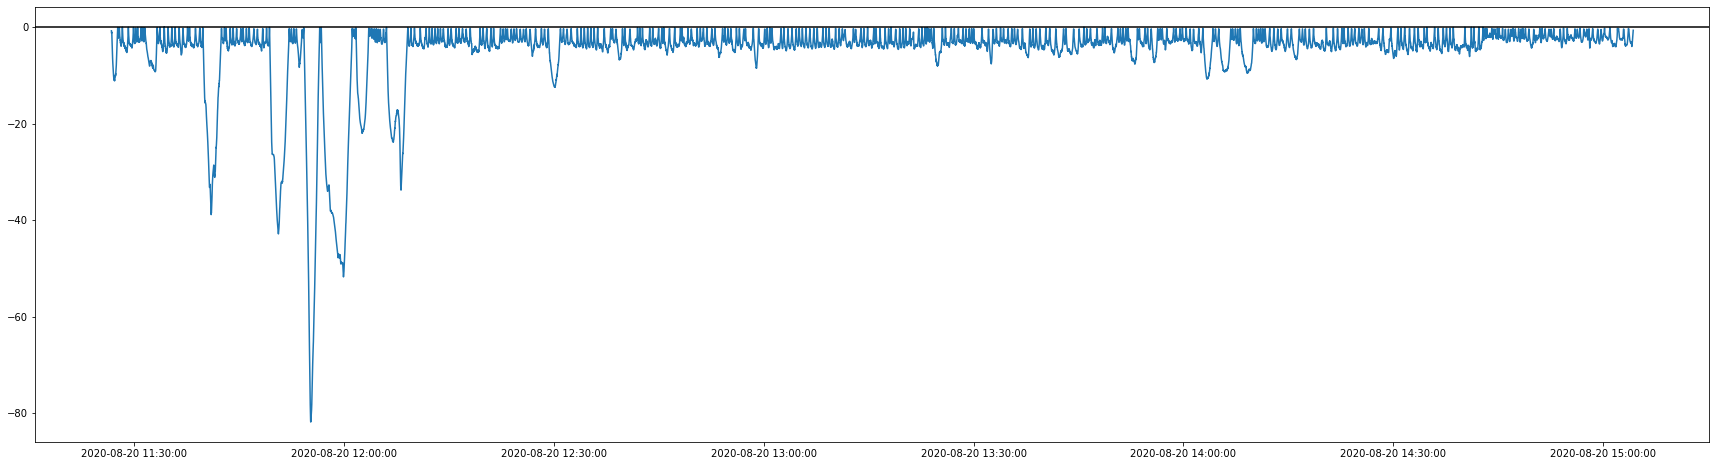

A113


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_85414/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


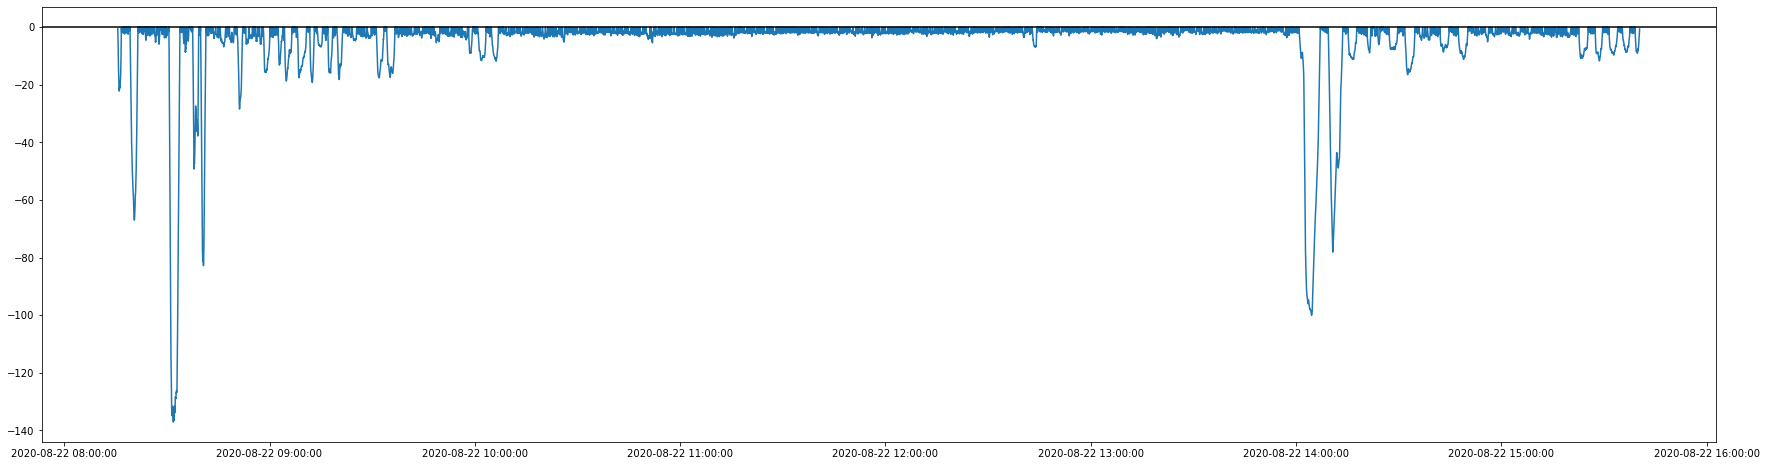

D21


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_85414/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


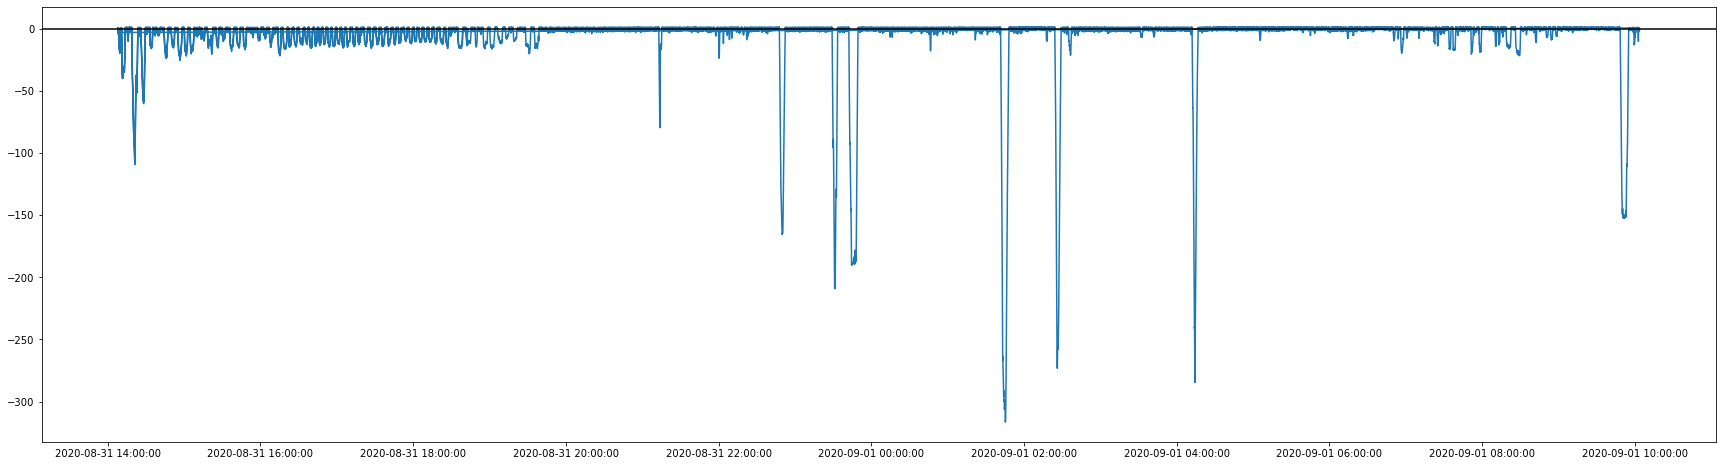

D26


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_85414/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


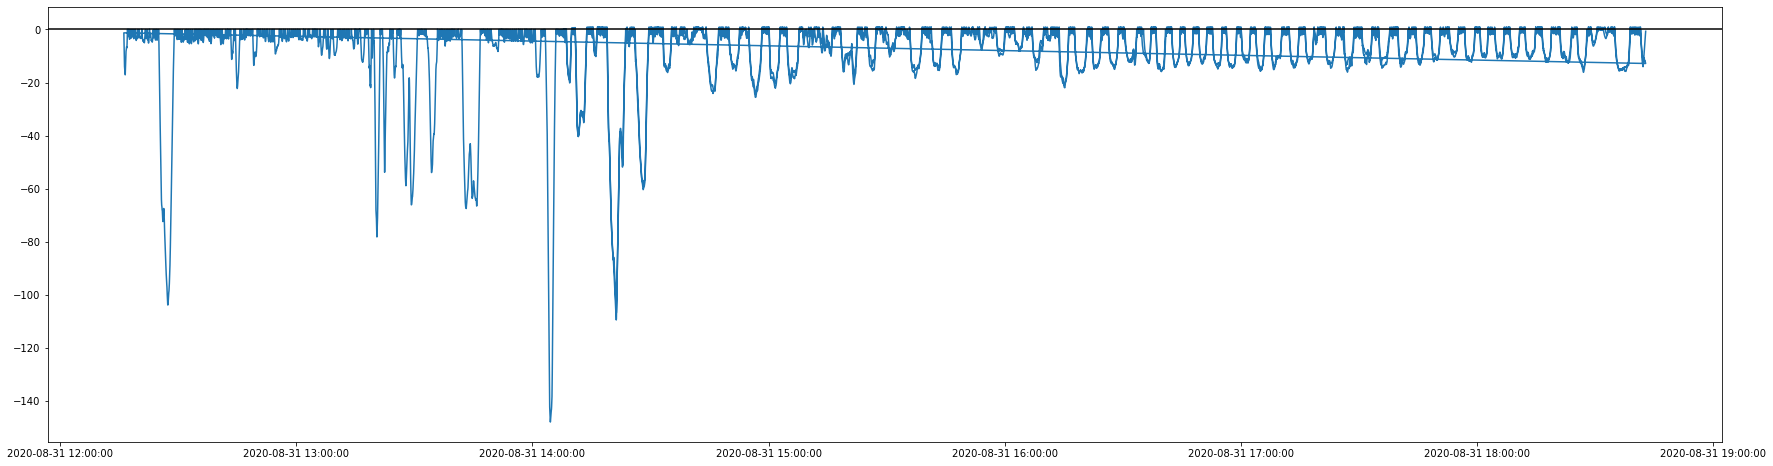

I107


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_85414/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


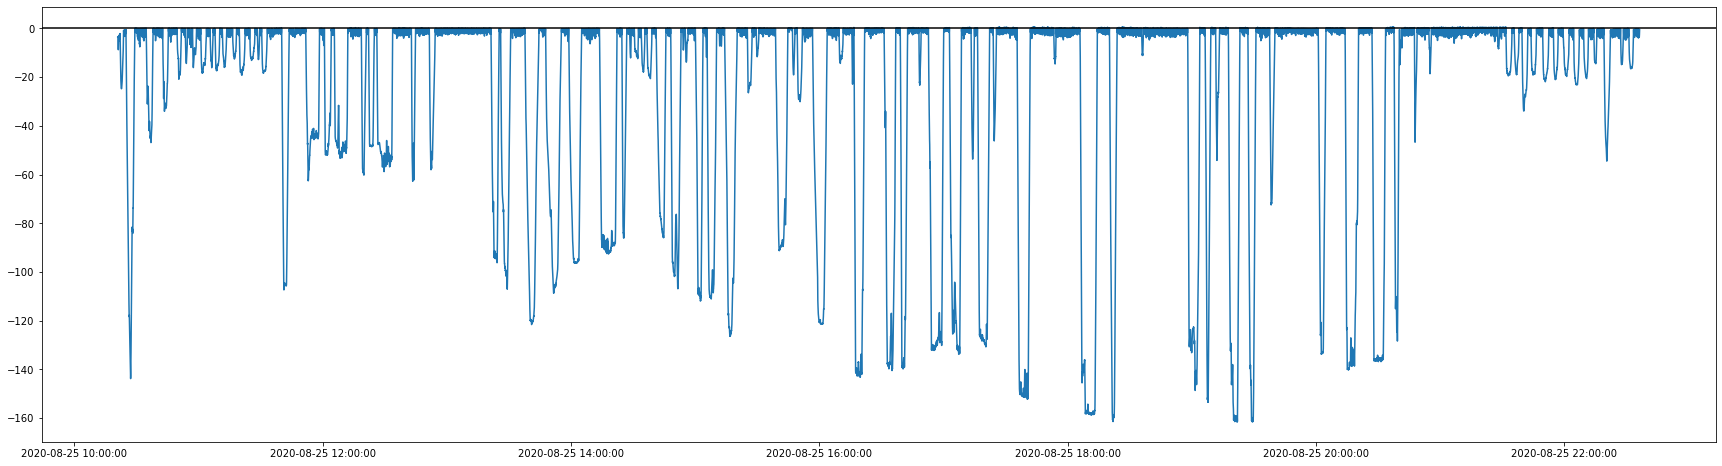

I129


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_85414/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


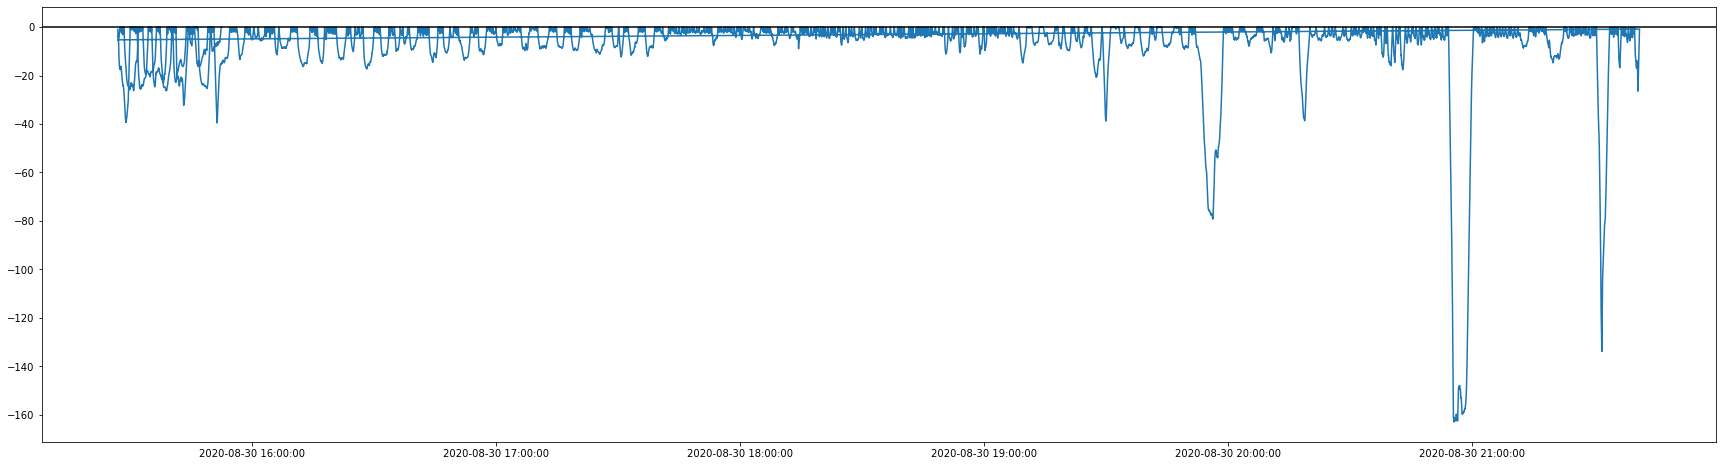

I145


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_85414/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


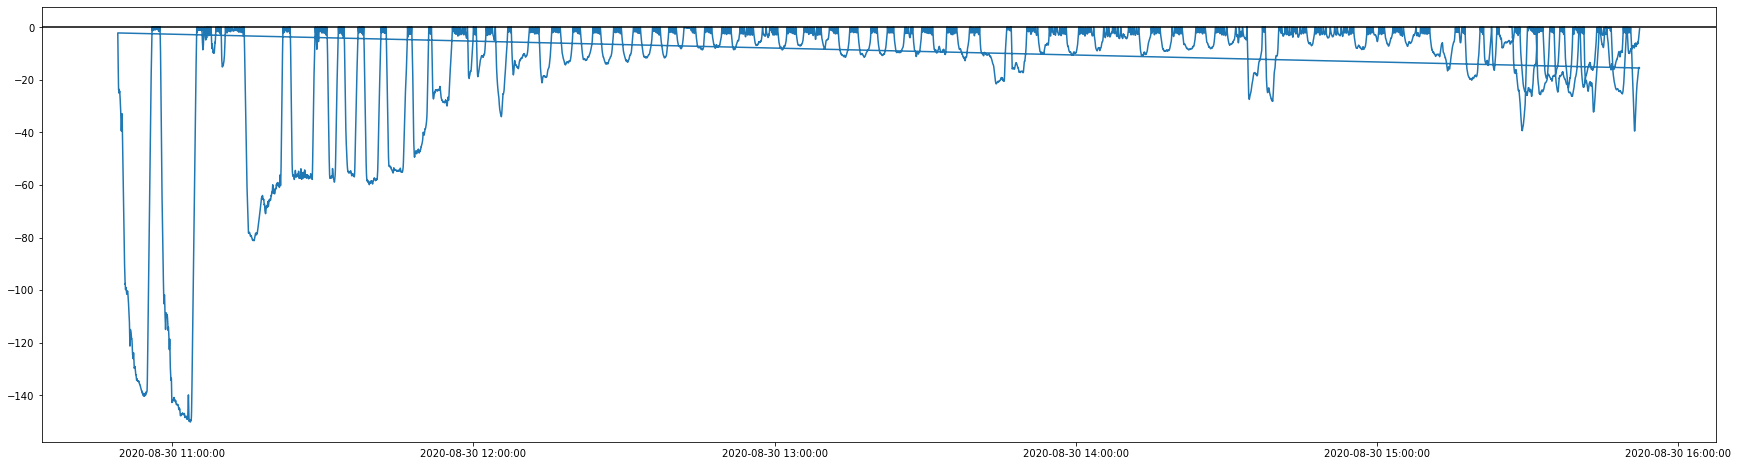

L87


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_85414/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


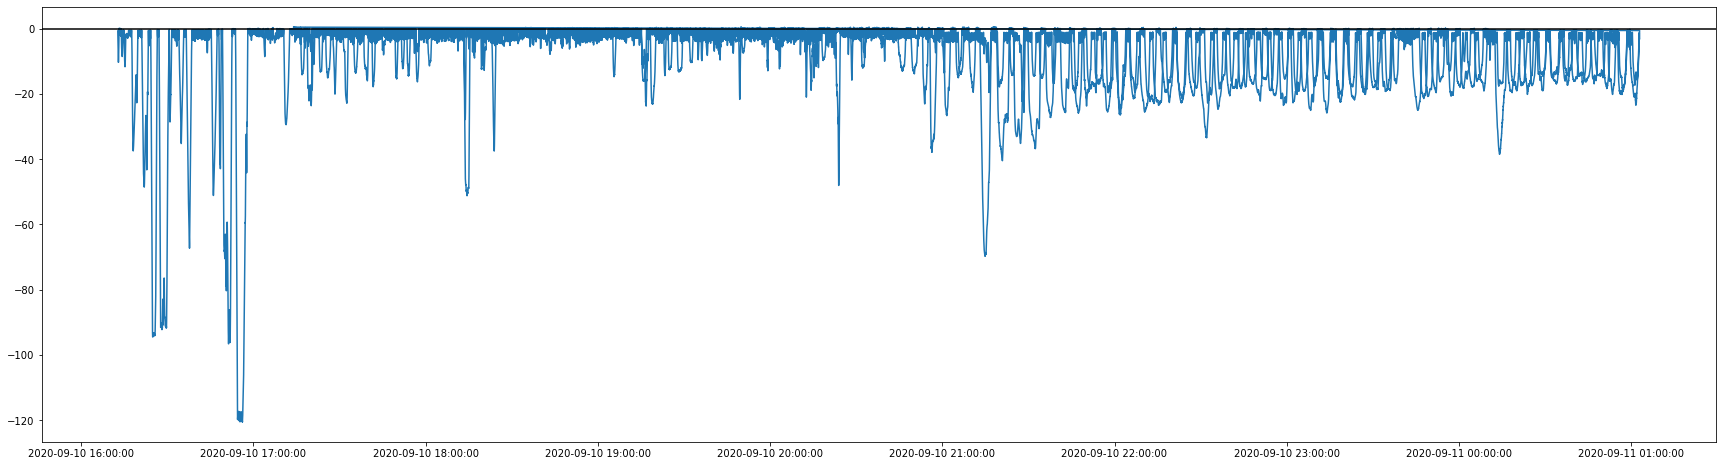

L88


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_85414/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


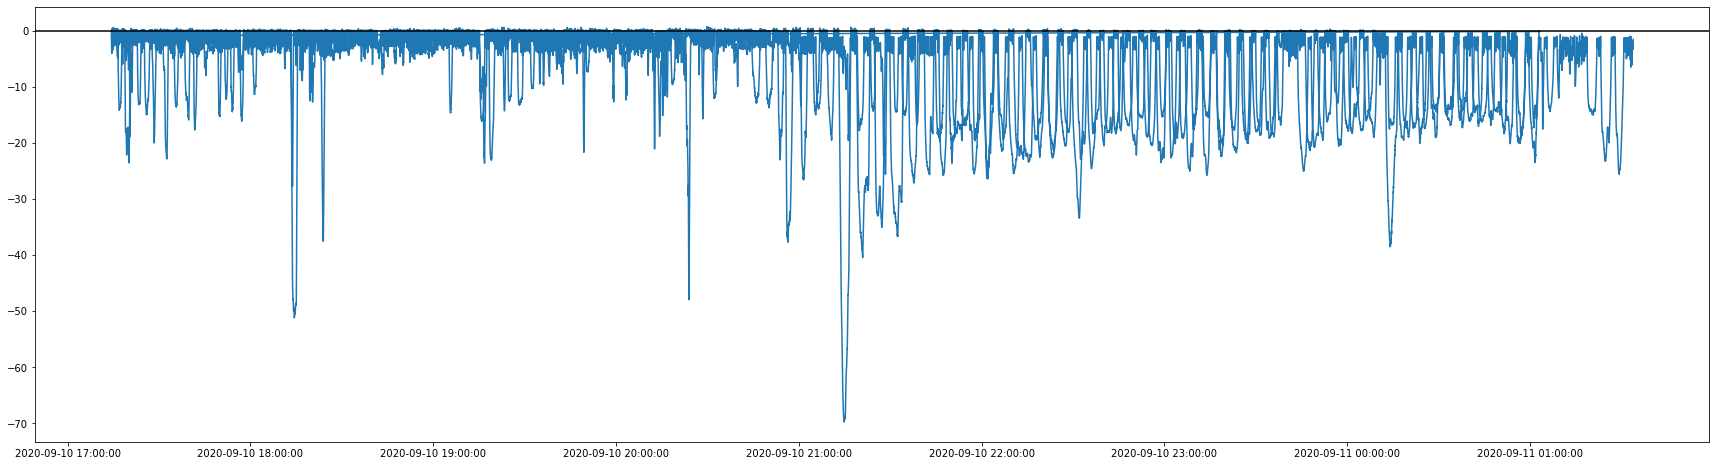

R48


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_85414/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


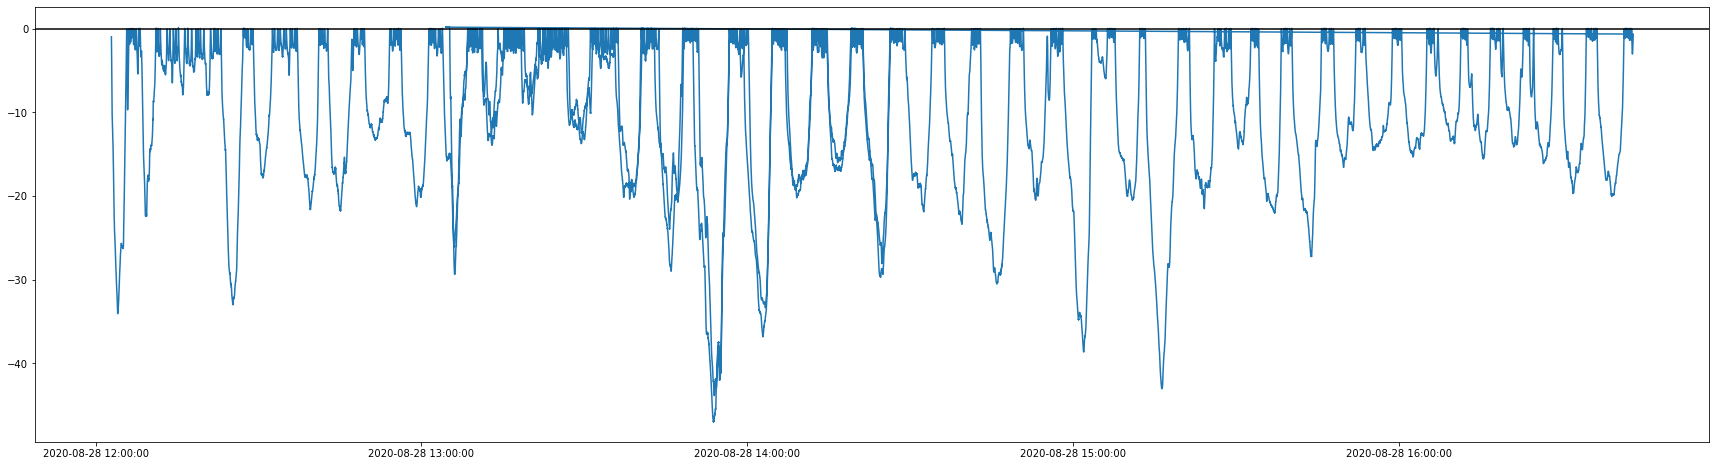

R58


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_85414/1254500412.py:8: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


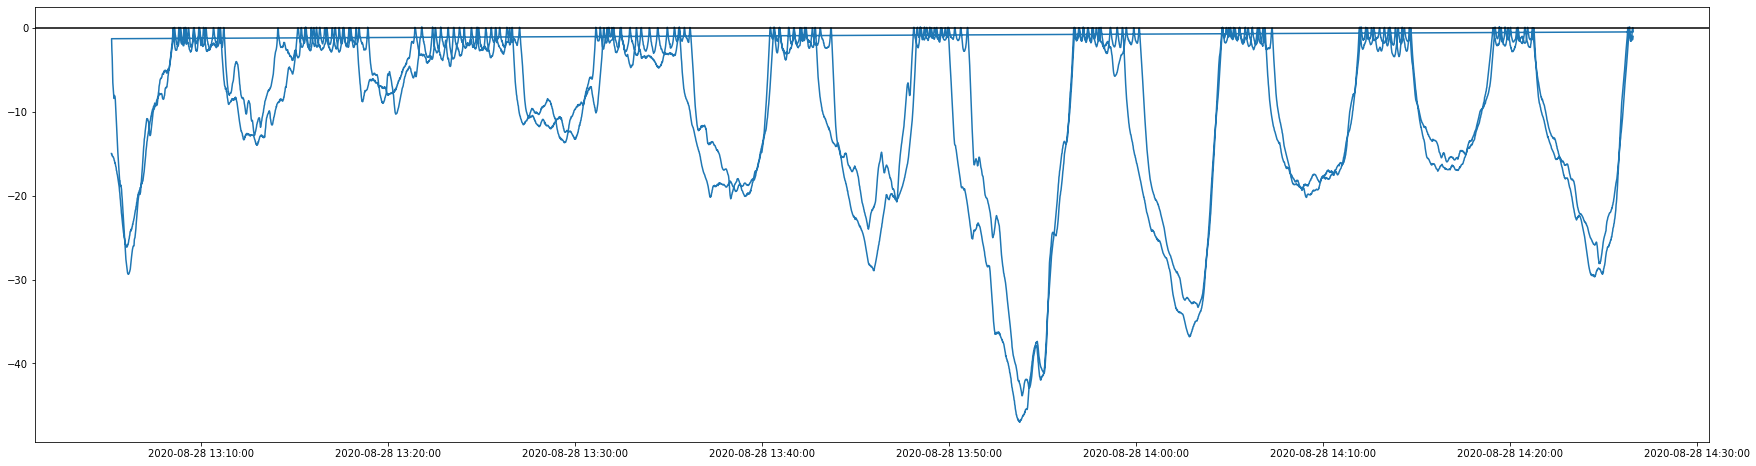

In [8]:
for whale in whales:
    print(whale)
    stime = df.loc[df["ID"].isin([whale]),"stime"].min()
    etime = df.loc[df["ID"].isin([whale]),"etime"].max()
    plt.figure(figsize=(30,8))
    plt.plot(raw_df[(raw_df["Time"] > stime) & (raw_df["Time"] < etime)].iloc[::50]["Time"],
             raw_df[(raw_df["Time"] > stime) & (raw_df["Time"] < etime)].iloc[::50]["Elevation"])
    plt.locator_params(axis='x', nbins=10)
    plt.axhline(0,color='k')
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.show()

# Train the HMM

In [9]:
#date = "Sep-25-2022" # both buffers
#date = "Sept-21-2022_large"
#date = "Sep-21-2022" # Beth's case study
#date = "Sep-19-2022" # No buffer for mini-batches, no buffer for weights
#date = "Sep-15-2022" # Make a buffer for mini-batches, but not for weights
#date = "Sep-16-2022" # Make a buffer for weights, but not for mini-batches
#date = "normal/Oct-31-2022" # no buffers, step size = 1/L
#date = "large/Nov-01-2022" # no buffers, step size = 1/L
#date = "normal/Nov-14-2022" # no buffers, step size = 1/3L
date = "large/Nov-14-2022" # no buffers, step size = 1/3L

param_folder = "/Volumes/One Touch/sublinear-HMM-inference/case_study/" + date
#param_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/" + date
plot_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/plt/case_study/" + date

methods = ["control","BFGS","SAGA","SVRG","GD","CG"]

K = [3,3]
#K = [2,3]

partial_Es = [0.0,0.5,1.0]

tol = 1e-3

optims = {}
times_to_converge = {}
epochs_to_converge = {}
lls = {}

#"experiment_1_2022-08-05_20-27-39"
#"experiment_1_2022-08-05_20-26-58"
#"experiment_1_2022-08-05_20-26-22"
#"experiment_1_2022-08-05_20-25-49"
#"experiment_1_2022-08-05_20-25-36"
#"experiment_1_2022-08-05_20-27-53"
#"experiment_1_2022-08-05_20-25-18"
#"experiment_1_2022-08-05_20-25-12"

#with open("../params/experiment_1_2022-08-05_20-25-49","rb") as f:
#    optims = pickle.load(f)

In [18]:
for method in methods:
    for partial_E in partial_Es:
        if method in ["BFGS","CG","GD","control"] and partial_E > 0.0:
            pass
        else:
            
            # get best ll
            best_ll = -np.infty
            #best_fname = param_folder + "/case_study_large_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)
            best_fname = param_folder + "/K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)
            
            # initialize lls
            lls[(method,partial_E)] = []
            
            # initialize epochs
            epochs_to_converge[(method,partial_E)] = []
            
            # initialize times
            times_to_converge[(method,partial_E)] = []
            
            for rand_seed in range(50):
                
                fname = param_folder + "/case_study_large_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                #fname = param_folder + "/K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                
                try:
                    with open(fname, 'rb') as f:
                        optim = pickle.load(f)
                    print("loaded file %s" % fname)
                except:
                    print("file %s does not exist" % fname)
                    continue
                
                # check for some issue (likely nan in theta)
                if len(optim.time_trace) == 0:
                    print("file %s didn't optimize." % fname)
                    continue
                    
                
                # get convergence ind
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                
                epochs_to_converge[(method,partial_E)].append(optim.epoch_trace[converge_ind])
                times_to_converge[(method,partial_E)].append(optim.time_trace[converge_ind])
                lls[(method,partial_E)].append(optim.log_like_trace[converge_ind])
                
                if optim.log_like_trace[-1] > best_ll:    
                    optims[(method,partial_E)] = optim
                    best_fname = fname
                    best_ll = optim.log_like_trace[-1]
                    
            print(best_fname)

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_000
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_001
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_002
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_003
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_004
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_005
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_006
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_007
loaded file /Vol

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_017
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_018
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_019
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_020
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_021
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_022
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_023
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_024
loaded file /Volumes/One Touch/sublinear

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_035
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_036
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_037
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_038
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_039
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_040
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_041
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_042
loaded file /Volumes/One Touch/sublinear

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_002
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_003
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_004
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_005
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_006
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_007
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_008
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_009
loaded file /Volumes/One Touch/sublinear

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_020
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_021
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_022
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_023
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_024
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_025
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_026
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_027
loaded file /Volumes/One Touch/sublinear

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_038
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_039
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_040
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_041
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_042
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_043
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_044
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_045
loaded file /Volumes/One Touch/sublinear

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_005
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_006
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_007
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_008
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_009
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_010
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_011
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_012
loaded file /Volumes/One Touch/sublinear-HMM-inference/c

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_024
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_025
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_026
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_027
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_028
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_029
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_030
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_031
loaded file /Volumes/One Touch/sublinear-HMM-inference/c

In [33]:
max_ll = -np.infty
for _,optim in optims.items():
    print(optim.log_like_trace[-1])
    if optim.log_like_trace[-1] > max_ll:
        self = optim
        max_ll = optim.log_like_trace[-1]

-3.1234561668209766
-3.1217723525284358
-3.1235220043264
-3.12103110357962
-3.1208861899976457
-3.122013350219164
-3.1227853773922787
-3.121749435548047
-3.140950713381556
-3.1247551627724213


# Repopulate the parameters

In [48]:
data

[{'diveDuration': 3.96081316959758,
  'maxDepth': 2.41703396774336,
  'postDiveInt': -0.08742157179075517},
 {'diveDuration': 2.39789527279837,
  'maxDepth': 0.829968519289633,
  'postDiveInt': -0.6931471805599453},
 {'diveDuration': 3.19867311755068,
  'maxDepth': 1.39313894401704,
  'postDiveInt': -0.6931471805599453},
 {'diveDuration': 3.90197266957464,
  'maxDepth': 1.67474698649732,
  'postDiveInt': -0.6931471805599453},
 {'diveDuration': 3.73766961828337,
  'maxDepth': 1.47383258011449,
  'postDiveInt': -0.6931471805599453},
 {'diveDuration': 2.77258872223978,
  'maxDepth': 1.26441397348651,
  'postDiveInt': -0.6931471805599453},
 {'diveDuration': 2.70805020110221,
  'maxDepth': 1.14324405259207,
  'postDiveInt': -0.36651292058166485},
 {'diveDuration': 3.3499040872746,
  'maxDepth': 1.16290302215214,
  'postDiveInt': -0.6931471805599453},
 {'diveDuration': 2.60268968544438,
  'maxDepth': 1.07462470867646,
  'postDiveInt': -0.36651292058166485},
 {'diveDuration': 2.52572864430826

In [34]:
self.data = data

self.log_alphas = np.zeros((self.T,self.K_total))
self.log_betas = np.zeros((self.T,self.K_total))

# p_Xt and p_Xtm1_Xt
self.p_Xt = np.zeros((self.T,self.K_total))
self.p_Xtm1_Xt = np.zeros((self.T,self.K_total,self.K_total))

# gradients wrt theta
self.grad_theta_t = [deepcopy(self.theta) for _ in range(self.T)]
self.grad_theta = deepcopy(self.theta)

# gradients wrt eta
self.grad_eta_t = [deepcopy(self.eta) for _ in range(self.T)]
self.grad_eta = deepcopy(self.eta)

# gradients wrt eta0
self.grad_eta0_t = [deepcopy(self.eta0) for _ in range(self.T)]
self.grad_eta0 = deepcopy(self.eta0)

self.E_step()
self.get_log_Gamma(jump=False)
self.get_log_Gamma(jump=True)
self.get_log_delta()

IndexError: list index out of range

# Get working Hessian

In [35]:
self.get_working_hess()

AttributeError: 'StochOptimizor' object has no attribute 'get_working_hess'

# Get Natural Hessian

In [ ]:
self.get_natural_hess()

# Get Confidence Intervals

In [ ]:
self.get_CIs()

# Get Monte Carlo parameters

In [ ]:
self.get_monte_carlo_theta(100)

# Use Monte-Carlo estimates to get Confidence Intervals for $P(X_t|Y)$

In [ ]:
self.get_fwd_bwd_prob_CIs(0.95)

# Print Parameters

In [37]:
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][1]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][2]))

array([[7.26666469e-01, 2.67041138e-01, 6.29239313e-03],
       [2.54563308e-01, 7.44482788e-01, 9.53903981e-04],
       [3.40067855e-03, 3.46026140e-06, 9.96595861e-01]])

array([[9.99613261e-01, 2.26125207e-04, 1.52018053e-04, 8.59552061e-06],
       [1.79435548e-10, 9.99999989e-01, 3.09858776e-09, 7.73203149e-09],
       [6.89617246e-05, 9.98222841e-01, 1.68497226e-03, 2.32245709e-05],
       [9.68926035e-13, 1.00000000e+00, 1.08097344e-12, 1.40960316e-10]])

array([[1.87865561e-07, 9.99999790e-01, 2.16727995e-08, 1.61914627e-10],
       [3.23543923e-03, 9.81319435e-01, 2.31363915e-18, 1.54451254e-02],
       [3.18155421e-03, 9.96790724e-01, 2.76686992e-05, 5.30580130e-08],
       [2.22413238e-07, 9.99989451e-01, 6.54502811e-07, 9.67179934e-06]])

array([[1.11511913e-04, 9.99884572e-01, 1.25181203e-06, 2.66398478e-06],
       [7.53620804e-04, 9.76480862e-01, 2.27655110e-02, 6.69177320e-09],
       [1.00370129e-06, 9.82885931e-01, 1.71095713e-02, 3.49411684e-06],
       [9.19322974e-02, 5.42004517e-01, 7.00700713e-02, 2.95993115e-01]])

In [38]:
display(self.theta)
#display(self.theta_SE)

display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][1]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][2]))
#display(self.Gamma_SE)

display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[0]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][0]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][1]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][2]))
#display(self.delta_SE)

[{'diveDuration': {'mu': array([2.15474824, 2.9399691 , 4.99855929, 4.49824727]),
   'log_sig': array([-0.74312815, -0.54520782, -0.61072308, -0.70935377])},
  'maxDepth': {'mu': array([-2.57507986,  0.69829361,  2.52193989,  2.0814295 ]),
   'log_sig': array([-0.0034128 , -0.65200724,  0.16551616, -1.09479805])},
  'postDiveInt': {'mu': array([12.1107378 ,  3.3342208 ,  2.70507227, 15.79800682]),
   'log_sig': array([ 2.72343712,  1.21401626, -0.27278484,  2.96409291])}},
 {'diveDuration': {'mu': array([2.15474824, 2.9399691 , 4.99855929, 4.49824727]),
   'log_sig': array([-0.74312815, -0.54520782, -0.61072308, -0.70935377])},
  'maxDepth': {'mu': array([-2.57507986,  0.69829361,  2.52193989,  2.0814295 ]),
   'log_sig': array([-0.0034128 , -0.65200724,  0.16551616, -1.09479805])},
  'postDiveInt': {'mu': array([12.1107378 ,  3.3342208 ,  2.70507227, 15.79800682]),
   'log_sig': array([ 2.72343712,  1.21401626, -0.27278484,  2.96409291])}},
 {'diveDuration': {'mu': array([2.15474824, 

array([[7.26666469e-01, 2.67041138e-01, 6.29239313e-03],
       [2.54563308e-01, 7.44482788e-01, 9.53903981e-04],
       [3.40067855e-03, 3.46026140e-06, 9.96595861e-01]])

array([[9.99613261e-01, 2.26125207e-04, 1.52018053e-04, 8.59552061e-06],
       [1.79435548e-10, 9.99999989e-01, 3.09858776e-09, 7.73203149e-09],
       [6.89617246e-05, 9.98222841e-01, 1.68497226e-03, 2.32245709e-05],
       [9.68926035e-13, 1.00000000e+00, 1.08097344e-12, 1.40960316e-10]])

array([[1.87865561e-07, 9.99999790e-01, 2.16727995e-08, 1.61914627e-10],
       [3.23543923e-03, 9.81319435e-01, 2.31363915e-18, 1.54451254e-02],
       [3.18155421e-03, 9.96790724e-01, 2.76686992e-05, 5.30580130e-08],
       [2.22413238e-07, 9.99989451e-01, 6.54502811e-07, 9.67179934e-06]])

array([[1.11511913e-04, 9.99884572e-01, 1.25181203e-06, 2.66398478e-06],
       [7.53620804e-04, 9.76480862e-01, 2.27655110e-02, 6.69177320e-09],
       [1.00370129e-06, 9.82885931e-01, 1.71095713e-02, 3.49411684e-06],
       [9.19322974e-02, 5.42004517e-01, 7.00700713e-02, 2.95993115e-01]])

array([1.67726855e-07, 9.99999831e-01, 1.17136920e-09])

array([2.50744301e-03, 9.92152250e-01, 5.34001705e-03, 2.89930041e-07])

array([9.37461607e-04, 5.96710563e-09, 9.95477744e-01, 3.58478823e-03])

array([4.01446793e-05, 9.99954583e-01, 3.89703604e-06, 1.37571213e-06])

In [38]:
np.exp(eta_2_log_Gamma(self.eta)[0].T)

array([[9.85601224e-01, 1.09929051e-02, 1.35570124e-03],
       [1.33688971e-02, 9.87776670e-01, 5.28724077e-04],
       [1.02987929e-03, 1.23042476e-03, 9.98115575e-01]])

In [39]:
pi00 = np.linalg.eig(np.exp(eta_2_log_Gamma(self.eta)[0].T))[1][:,0]
pi00 = pi00 / sum(pi00)

pi01 = np.linalg.eig(np.exp(eta_2_log_Gamma(self.eta)[0].T))[1][:,1]
pi01 = pi01 / sum(pi01)

pi02 = np.linalg.eig(np.exp(eta_2_log_Gamma(self.eta)[0].T))[1][:,2]
pi02 = pi02 / sum(pi02)

pi10 = np.linalg.eig(np.exp(eta_2_log_Gamma(self.eta)[1][0].T))[1][:,0]
pi10 = pi10 / sum(pi10)
pi11 = np.linalg.eig(np.exp(eta_2_log_Gamma(self.eta)[1][1].T))[1][:,0]
pi11 = pi11 / sum(pi11)

display(pi00)
display(pi01)
display(pi02)

display(pi10)
display(pi11)

array([ 4.03909468e+13, -4.07531580e+13,  3.62211214e+11])

array([0.29009601, 0.3335625 , 0.37634149])

array([ 5.47529930e+12,  7.23020245e+12, -1.27055017e+13])

array([0.48312424, 0.51006811, 0.00680765])

array([-6.37148229e+15,  4.86403028e+12,  6.36661826e+15])

# Plot emission distributions with error bounds

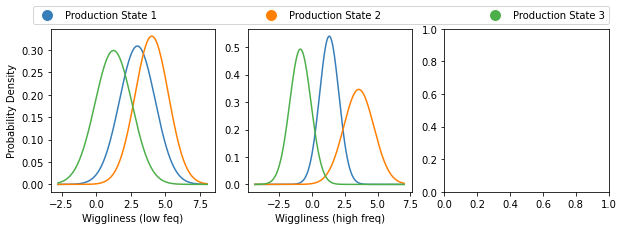

In [41]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# define colors
coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]

K_total = self.K[1]
perc = 0.95

fig,ax = plt.subplots(1,3,figsize=(10,3))

x_labels = {"diveDuration" : "Dive Duration (s)",
            "maxDepth"     : "Maximum Depth (m)",
            "avg_bot_htv"  : "Average Bottom RHTV (rad/s)",
            "postDiveInt"  : "Post Dive Interval (seconds)",
            "w_low"        : "Wiggliness (low feq)",
            "w_high"       : "Wiggliness (high freq)"}

for fignum,feature in enumerate(self.features):
    
    # get bounds
    min_mu = np.min([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_mu = np.max([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_sig = np.exp(np.max([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))
    
    x = np.linspace(min_mu-3*max_sig,max_mu+3*max_sig,1000)
    
    # see if we are using a truncnorm
    a = self.features[feature]["lower_bound"]
    b = self.features[feature]["upper_bound"]
    if not a is None:
        a = np.concatenate([self.features[feature]["lower_bound"] for _ in self.theta])
    if not b is None:
        b = np.concatenate([self.features[feature]["upper_bound"] for _ in self.theta])

    # now get the y values for each x
    y0 = np.zeros((1000,K_total))

    # true ys
    mu = np.concatenate([theta_fine[feature]['mu'] for theta_fine in self.theta])
    sig = np.exp(np.concatenate([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))

    for state in range(K_total):
        if (not a is None) and (not b is None):
            y0[:,state] = truncnorm.pdf(x,a=(a[state]-mu[state])/sig[state],
                                          b=(b[state]-mu[state])/sig[state],
                                          loc=mu[state],scale=sig[state])
        else:
            y0[:,state] = norm.pdf(x,mu[state],sig[state])
    
    if feature == "maxDepth":
        ax[fignum].axvline(np.log(20),color='k',linestyle='--')
        ax[fignum].axvline(np.log(5),color='k',linestyle='--')
    
    for state in range(self.K[1]):
        
        # plot distribution
        ax[fignum].plot(x,y0[:,state],
                        color=CB_color_cycle[state])
        
    # add labels
    if fignum == 0:
        ax[fignum].set_ylabel("Probability Density")

    ax[fignum].set_xlabel(x_labels[feature])
    #ax[fignum].set_xscale('log')
        
leg_labels = ['Production State %d'%(i+1) for i in range(self.K[1])]

legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                   markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])]

fig.legend(handles=legend_elements,prop={'size': 10}, ncol=self.K[1], mode="expand", borderaxespad=0.,
             bbox_to_anchor=(0.1, 0.9, 0.8, .1), loc='lower left')

#fig.tight_layout()

fig.savefig(plot_folder+'/emission_dists_K_%d_%d_nWhales_%d.png' % (self.K[0],self.K[1],len(whales)),
            dpi=300,
            bbox_inches='tight')

# Plot Dive Profiles

In [42]:
self.p_fine = np.zeros((self.T,self.K[1]))
self.p_coarse = np.zeros((self.T,self.K[0]))

# get p_coarse, p_fine, and CIs
for k0 in range(self.K[0]):
    self.p_coarse[:,k0] = np.sum(self.p_Xt[:,(k0*self.K[1]):((k0+1)*self.K[1])],1)

for k1 in range(self.K[1]):
    self.p_fine[:,k1] = np.sum(self.p_Xt[:,k1::self.K[1]],1)

In [44]:
whale = "I145"
df0 = df.reset_index().drop("index",axis=1).reset_index()
ind = min(df0[df0.ID == whale]["index"])
span = len(df0[df0.ID == whale]) - 2

print(ind)
print(span)

5358
455


A100
354
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
2

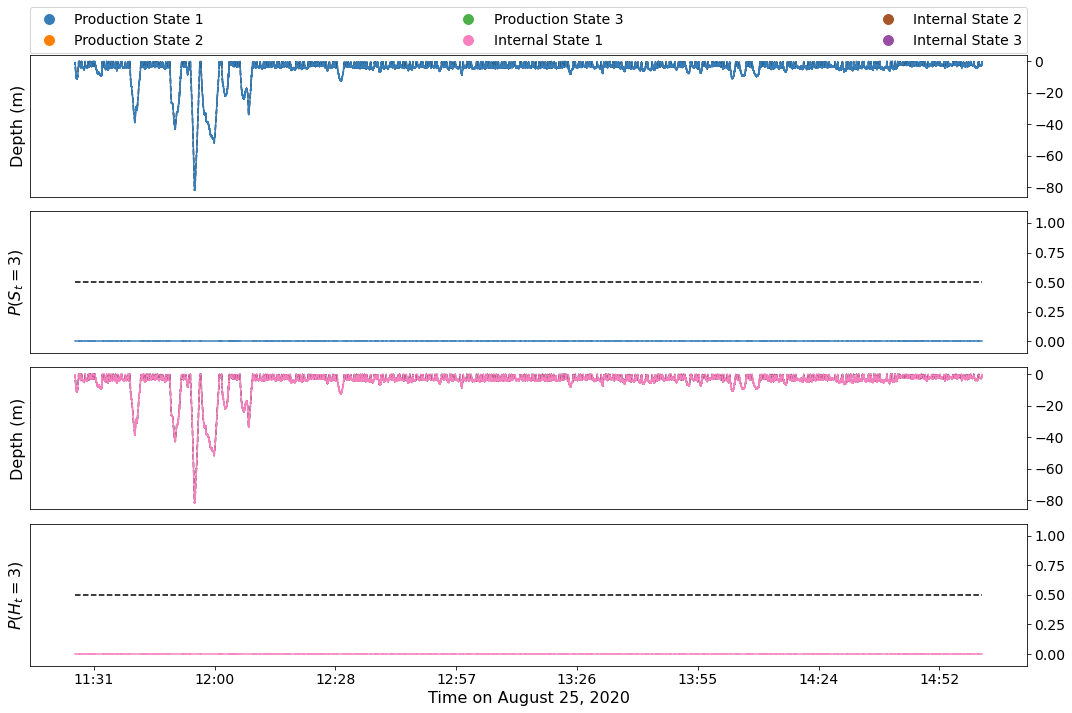

In [47]:
for whale in ["A100"]:#whales:
    
    print(whale)

    df0 = df.reset_index().drop("index",axis=1).reset_index()
    ind = min(df0[df0.ID == whale]["index"])
    span = len(df0[df0.ID == whale]) - 2
    
    print(span)

    # get the dive types
    ML_divetype = np.argmax(self.p_fine,1)
    ML_bouttype = np.argmax(self.p_coarse,1)

    # define colors
    coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
    fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]

    fig,ax = plt.subplots(4,1,figsize=(15,10))

    # get legend
    labels = ['Production State 1','Production State 2','Production State 3',
              'Internal State 1','Internal State 2']
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0],
                                      markerfacecolor=fine_colors[0], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[1],
                                      markerfacecolor=fine_colors[1], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[2],
                                      markerfacecolor=fine_colors[2], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[3],
                                      markerfacecolor=coarse_colors[0], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[4],
                                      markerfacecolor=coarse_colors[1], markersize=12)]
                       #Patch(facecolor=coarse_colors[0], alpha=0.5, label=labels[4]),
                       #Patch(facecolor=coarse_colors[1], alpha=0.5, label=labels[5])]

    leg_labels = ['Production State %d'%(i+1) for i in range(self.K[1])] + \
                 ['Internal State %d'%(i+1) for i in range(self.K[0])]

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                       markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])] + \
                      [Line2D([0], [0], marker='o', color='w', label=leg_labels[i+self.K[1]],
                       markerfacecolor=coarse_colors[i], markersize=12) for i in range(self.K[0])]


    s_bout = df["stime"].iloc[ind]
    bouttype = ML_bouttype[ind]

    for divenum in range(ind,ind+span):

        print(divenum)

        # plot dashed line
        dive_df = raw_df[raw_df["Time"] <= df["stime"].iloc[divenum+1]]
        dive_df = dive_df[dive_df["Time"] >= df["stime"].iloc[divenum]]
        dive_df = dive_df

        # plot dive profiles
        ax[0].plot(pd.to_datetime(dive_df["Time"]),
                   dive_df["Elevation"],
                   "k--")

        ax[2].plot(pd.to_datetime(dive_df["Time"]),
                   dive_df["Elevation"],
                   "k--")

        # show color of bout / dive type
        # dive_df = raw_df[raw_df["divenum"] == df["divenum"].iloc[divenum]]

        # plot dive profiles with color
        ax[0].plot(pd.to_datetime(dive_df["Time"]),
                   dive_df["Elevation"],
                   color=fine_colors[ML_divetype[divenum]])

        ax[2].plot(pd.to_datetime(dive_df["Time"]),
                   dive_df["Elevation"],
                   color=coarse_colors[ML_bouttype[divenum]])

        # show probs of fine-scale states
        ax[1].plot(pd.to_datetime([df.iloc[divenum]["stime"],df.iloc[divenum+1]["stime"]]),
                   [self.p_fine[divenum,(self.K[1]-1)],self.p_fine[divenum,(self.K[1]-1)]],
                   color=fine_colors[ML_divetype[divenum]])

        # show probs of coarse-scale states
        ax[3].plot(pd.to_datetime([df.iloc[divenum]["stime"],df.iloc[divenum+1]["stime"]]),
                   [self.p_coarse[divenum,(self.K[0]-1)],self.p_coarse[divenum,(self.K[0]-1)]],
                    color=coarse_colors[ML_bouttype[divenum]])

    # draw lines for probabilites
    ax[3].plot([df["stime"].iloc[ind],df["stime"].iloc[ind+span]],[0.5,0.5],'k--')
    ax[1].plot([df["stime"].iloc[ind],df["stime"].iloc[ind+span]],[0.5,0.5],'k--')

    # position legend
    ax[0].legend(handles=legend_elements,prop={'size': 14}, ncol=3, mode="expand", borderaxespad=0.,
                 bbox_to_anchor=(0., 1.01, 1., .102), loc='lower left')

    for ax0 in ax:
        ax0.set_xticks([])

    ax[0].set_ylabel('Depth (m)',fontsize=16)
    ax[1].set_ylabel(r'$P(S_t = %d)$'%self.K[1],fontsize=16)

    ax[2].set_ylabel('Depth (m)',fontsize=16)
    ax[3].set_ylabel(r'$P(H_t = %d)$'%self.K[0],fontsize=16)

    ax[1].set_ylim([-0.1,1.1])
    ax[3].set_ylim([-0.1,1.1])

    ax[0].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[2].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[3].yaxis.set_major_locator(plt.MaxNLocator(5))


    ax[-1].set_xlabel("Time on August 25, 2020",fontsize=16)
    ax[-1].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))

    for ax0 in ax:
        ax0.yaxis.tick_right()
        for item in ax0.get_yticklabels():
            item.set_fontsize(14)
        for item in ax0.get_xticklabels():
            item.set_fontsize(14)

    plt.tight_layout()
    plt.savefig(plot_folder+'/decoded_dives_kw_%s_K_%d_%d_nWhales_%d.png'%(whale,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()

# Plot Pseudoresiduals

In [ ]:
for feature in self.features[1]:

    print(feature)
    
    pseudoresids = self.get_pseudoresids(feature)
        
    plt.hist(pseudoresids,bins=25,density=True,alpha=0.5,color='k')
    x = np.linspace(-5,5,1000)
    plt.plot(x,norm.pdf(x),'k-')
    plt.title("Pseudoresiduals of %s" % x_labels[feature])
    plt.xlabel("Pseudoresidual")
    plt.ylabel("Density")
    plt.savefig('../plt/pseudo_hist_%s_K_%d_%d_nWhales_%d.png'%(feature,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()
    
    plt.plot(pseudoresids,'.')
    plt.title("Pseudoresiduals of %s" % x_labels[feature])
    plt.ylabel("Pseudoresidual")
    plt.xlabel(r"t")
    plt.plot(np.zeros_like(pseudoresids),'k--')
    plt.savefig('../plt/pseudo_%s_K_%d_%d_nWhales_%d.png'%(feature,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()
    
    sm.qqplot(np.array(pseudoresids), line='45')
    plt.title("Pseudoresidual QQ plot of %s" % x_labels[feature])
    plt.savefig('../plt/pseudo_qq_%s_K_%d_%d_nWhales_%d.png'%(feature,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()

# Save Results